In [2]:
import pandas as pd
import numpy as np
import cv2
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_csv = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Train.csv')
test_csv = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')

print(train_csv.head())

IMG_HEIGHT = 32
IMG_WIDTH = 32

def load_images(df, base_dir):
    images = []
    labels = []
    for idx, row in df.iterrows():
        img_path = os.path.join(base_dir, row['Path'])
        img = cv2.imread(img_path)
        if img is None:
            print(f"[Warning] Could not read image: {img_path}")
            continue
        x1, y1, x2, y2 = row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']
        roi = img[y1:y2, x1:x2]
        roi = cv2.resize(roi, (IMG_WIDTH, IMG_HEIGHT))
        roi = roi / 255.0
        images.append(roi)
        labels.append(row['ClassId'])
    return np.array(images), np.array(labels)

X_train, y_train = load_images(train_csv, '/kaggle/input/gtsrb-german-traffic-sign')
X_test, y_test = load_images(test_csv, '/kaggle/input/gtsrb-german-traffic-sign')


   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

num_classes = len(train_csv['ClassId'].unique())
y_train = to_categorical(y_train, num_classes)
y_val   = to_categorical(y_val, num_classes)
y_test  = to_categorical(y_test, num_classes)


In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()
history_cnn = cnn_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)


test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=2)
print(f"CNN Test Accuracy: {test_acc:.4f}")




/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,355 (2.10 MB)

 Trainable params: 549,355 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.3550 - loss: 2.4205 - val_accuracy: 0.9162 - val_loss: 0.3375
Epoch 2/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.8241 - loss: 0.5650 - val_accuracy: 0.9715 - val_loss: 0.1223
Epoch 3/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.8988 - loss: 0.3192 - val_accuracy: 0.9839 - val_loss: 0.0757
Epoch 4/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.9269 - loss: 0.2324 - val_accuracy: 0.9857 - val_loss: 0.0608
Epoch 5/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.9429 - loss: 0.1832 - val_accuracy: 0.9903 - val_loss: 0.0425
Epoch 6/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.9490 - loss: 0.1609 - val_accuracy: 0.9911 - val_loss: 0.0426
Epoch 7/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.9559 - loss: 0.1336 - val_accuracy: 0.9930 - val_loss: 0.0331
Epoch 8/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.9626 - loss: 0.1117 - 

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


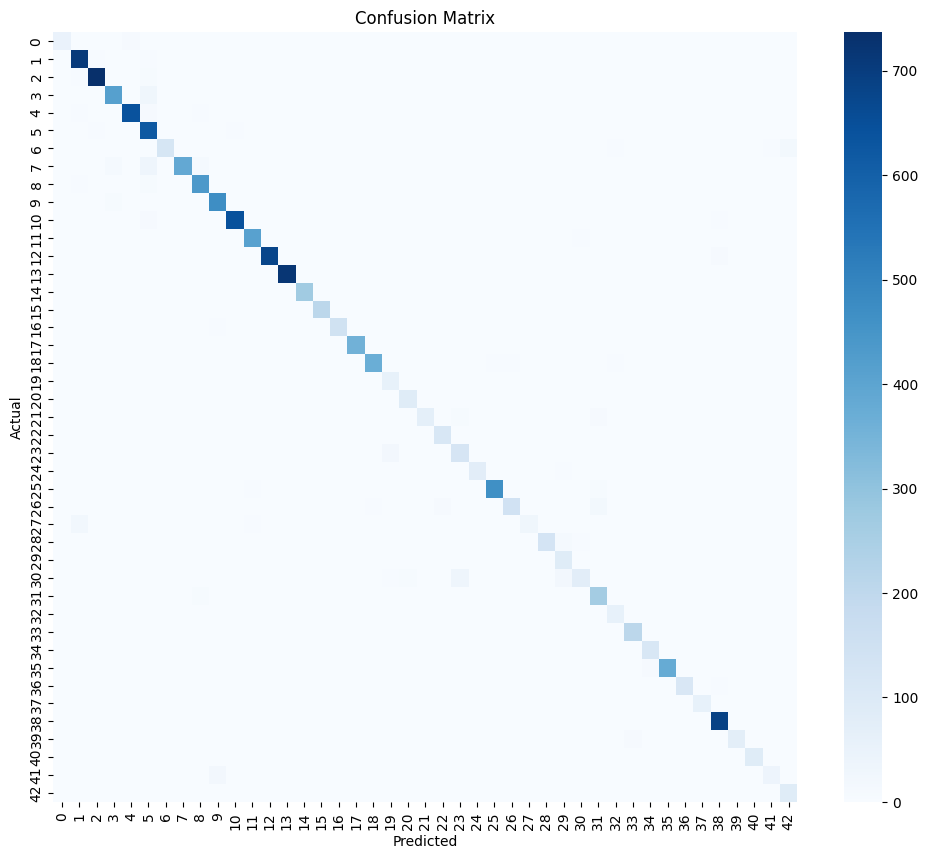

In [24]:
y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,     
    width_shift_range=0.1,  
    height_shift_range=0.1,
    zoom_range=0.1,         
    shear_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)
datagen.fit(X_train)


In [27]:
history_cnn = cnn_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_val, y_val)
)

test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=2)
print(f"CNN Test Accuracy with Augmentation: {test_acc:.4f}")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.7532 - loss: 0.8754 - val_accuracy: 0.9940 - val_loss: 0.0380
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.8647 - loss: 0.4430 - val_accuracy: 0.9949 - val_loss: 0.0237
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.8942 - loss: 0.3384 - val_accuracy: 0.9964 - val_loss: 0.0176
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.9141 - loss: 0.2854 - val_accuracy: 0.9954 - val_loss: 0.0182
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.9250 - loss: 0.2402 - val_accuracy: 0.9954 - val_loss: 0.0171
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.9347 - loss: 0.2132 - val_accuracy: 0.9964 - val_loss: 0.0152
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.9388 - loss: 0.2000 - val_accuracy: 0.9964 - val_loss: 0.0131
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 42s 37ms/step - accuracy: 0.9480 - loss: 0.1641 - val_accurac

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


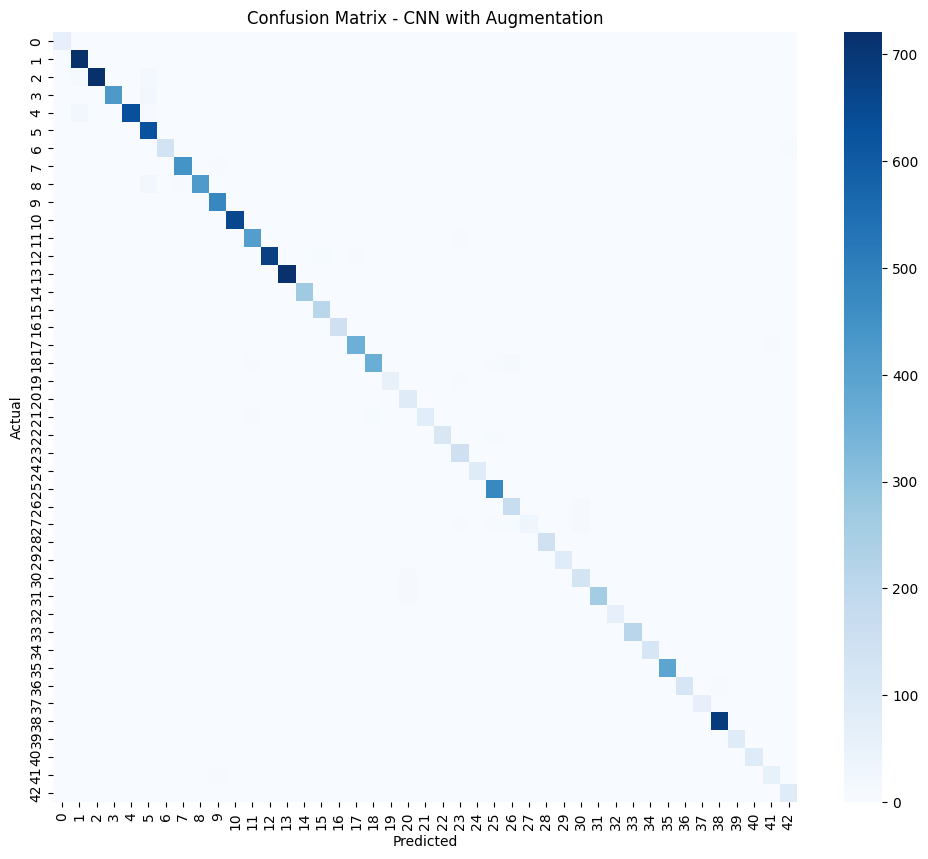

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred_aug = np.argmax(cnn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm_aug = confusion_matrix(y_true, y_pred_aug)

plt.figure(figsize=(12,10))
sns.heatmap(cm_aug, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - CNN with Augmentation")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()